<a href="https://colab.research.google.com/github/manuelescola/myprojects/blob/main/03_Facial_recognition_with_CNNs_and_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial recognition with Convolutional Neural Networks and Transfer Learning

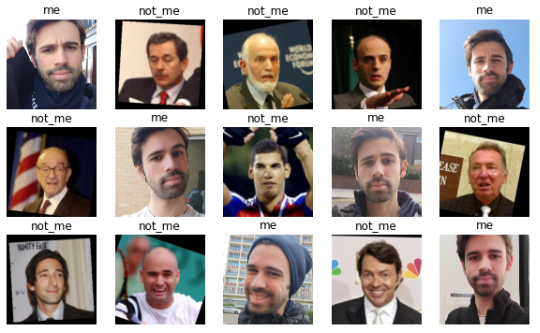

_Note: This notebook has been designed to be run in Google Collab. If run it locally or in other platforms, please make sure the dataset is loaded correctly into the notebook._

# 1. Introduction

During any social event, from conferences to informal parties, a large number of pictures is taken. This can be a problem the next day, when you have to go through all of them to locate which ones you appear in. This can be tedious and boring, considering that you usually only appear in a small percentage of them.

The aim of this paper is to analyse to what extent a convolutional neural network (CNN) trained with transfer learning is able to perform face recognition tasks when trained with few instances.

The article is structured as follows. Chapter II imports and preprocesses a dataset with photographs. Chapter III describes and designs the network used. In Chapter IV, four experiments are carried out. The first experiment is performed by training the network from scratch, without transfer learning. The second experiment consists of training only the final linear layer and keeping the rest of the weights the same. The third experiment fine-tunes all the pre-trained weights of the network. And the fourth experiment performs the training in two steps: first it trains only the final layer with a larger learning rate and then trains the whole network with the same learning rate as in the previous experiments. Chapter V contains the error analysis of the models. Finally, the last chapter presents the conclusions, limitations and future research.

The Annex contains a sample of the images of myself used in this paper.

# 2. Setting up the notebook

In [ ]:
# Import numpy, pandas, random and re
import numpy as np
import pandas as pd
import random
import re

# importing libraries
import zipfile
from PIL import Image
import os
import random 
from skimage import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import albumentations as A
import torchvision
from tqdm import tqdm

# To avoid problems of reproducibility, 
# the following function is called in all 
# the cells which conduct some random operation.

RAND_SEED = 100
def set_seeds(RAND_SEED): 
    random.seed(RAND_SEED) 
    np.random.seed(RAND_SEED) 
    torch.manual_seed(RAND_SEED)
    torch.cuda.manual_seed(RAND_SEED)            
    torch.backends.cudnn.deterministic = True

# 3. Data preprocessing

## 3.1. Importing the dataset from google drive


The following code imports a zip file from my google drive and extracts its contents. The result is a folder called "new_people". This folder contains two subfolders with pictures of me and famous people, respectively.

The photos in which I appear were taken with different backgrounds and attire (e.g. with and without glasses, with and without a hat, with different shirts and coats, with and without putting on the hood of my coat, etc.). They were taken during the last weeks of the term. Some of them include colour filters to make the task more difficult to the neural network.

The photos of the celebrities were obtained from http://vis-www.cs.umass.edu/lfw/.

In [ ]:
%%capture 
# https://drive.google.com/file/d/1EF0MhWYcwFHMshwd6agx9pAMMo5cri-T/view?usp=share_link
! gdown --id 1EF0MhWYcwFHMshwd6agx9pAMMo5cri-T

In [ ]:
# extract the contents of the flowers.zip file to the current directory ('.')
with zipfile.ZipFile('new_people.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

Since we will process the photos to make them all have the same dimensions, it is necessary to crop the pictures to prevent them from being deformed. This is a necessary step because the model found it very easy to detect my pictures when being deformed (probably because they were the only ones which contained extremely elongated faces).

In [ ]:
# Define the path to the folder containing the images
folder_path = '/content/new_people/me'

# Define the target dimensions for the cropped images
width = 2916
height = 2916

# Loop through each file in the folder (should take 2 minutes on GPU)
for filename in os.listdir(folder_path):
    # Define the path to the current file
    file_path = os.path.join(folder_path, filename)
    # Open the image using Pillow
    with Image.open(file_path) as img:
        # Get the current dimensions of the image
        current_width, current_height = img.size
        # Calculate the coordinates for the cropped image
        left = (current_width - width) / 2
        top = (current_height - height) / 2
        right = (current_width + width) / 2
        bottom = (current_height + height) / 2
        # Crop the image using the calculated coordinates
        cropped_img = img.crop((left, top, right, bottom))
        # Resize the cropped image to the target dimensions
        resized_img = cropped_img.resize((width, height))
        # Rotate the cropped image 90 degrees to the left
        resized_img = resized_img.transpose(method=Image.ROTATE_90)
        # Define the path to the new file
        new_file_path = os.path.join(folder_path, 'cropped_' + filename)
        # Save the resized image with a new filename
        resized_img.save(new_file_path)
        # Delete the original file
        os.remove(file_path)


## 3.2. Labeling the dataset

As mentioned, the dataset is divided in 2 different folders. The first folder contains pictures of me. The second one, other people's pictures. Part of the code for this task was obtained from
https://www.sensiocoders.com/

In [ ]:
# list all the files in new_people folder and stores the result in a list
PATH = 'new_people'
classes = os.listdir(PATH)
classes

['me', 'not_me']

We will assign the label "me" to the pictures in the first folder and "not_me" to the pictures in the second one. The following function allows us to quickly label all the photos in each subfolder. The code explains each step in the comments. We can see that the dataset is well balanced (215 photos per category) to prevent the model from becoming biased towards predicting the majority class.

In [ ]:
imgs, labels = [], []

for i, lab in enumerate(classes):
  # lists files in subdirectory f'{PATH}/{lab}' and stores result in a list
  paths = os.listdir(f'{PATH}/{lab}')
  print(f'Folder: {lab}. Number of images: {len(paths)}')

  # Loop to select only those file names in paths that end with "jpg"
  paths = [p for p in paths if p[-3:] == "jpg"]

  # Loop to append a list of image file paths to a list
  imgs += [f'{PATH}/{lab}/{img}' for img in paths]

  # Setting the labels. 
  # Each label set to i (the index of the current lab) 
  # The length is equal to the number of selected images for the current lab
  labels += [i]*len(paths)

Folder: me. Number of images: 215
Folder: not_me. Number of images: 215


The following code shows a sample of the dataset once it has been labeled.

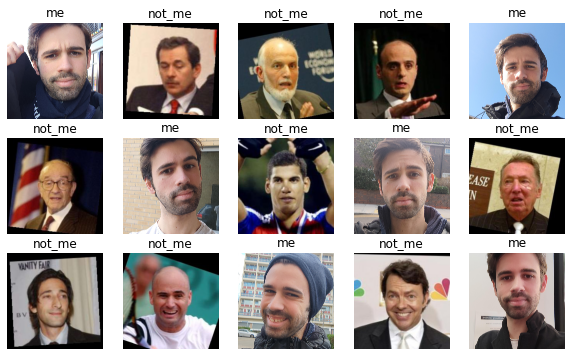

In [ ]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(imgs)-1)
    img = io.imread(imgs[ix])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(classes[labels[ix]])
plt.show()

## 3.3. Preparing training and validation sets

In [ ]:
# We divide the dataset into training, validation and test sets.
set_seeds(RAND_SEED)
train_imgs, val_imgs, train_labels, val_labels = train_test_split(
    imgs, labels, test_size=0.3, stratify=labels, 
    random_state=RAND_SEED)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    val_imgs, val_labels, test_size=0.3, stratify=val_labels, 
    random_state=RAND_SEED)

len(train_imgs), len(val_imgs), len(test_imgs)
# note that the we had 215+215 files and now we have 429
# this is because one file was droped when creating the list
# for not being a jpg.

(300, 90, 39)

After splitting the data, we create the variable device to tell our code if it is being trained on GPU or CPU. We also create our Dataset and DataLoader objects to be able to give the images to our models.

In [ ]:
# sets the device variable to "cuda" if a GPU is available, or "cpu" otherwise
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):

    # load the image
    img = io.imread(self.X[ix])

    # apply transformations to ensure that all images are of the same size
    if self.trans:
      img = self.trans(image=img)["image"]

    # normalise the data representing the images to be between 0 and 1
    # the dimensions must be changed as the CNNs in pytorch expect the first 
    # dimension to be the number of channels, and yet when reading the images 
    # the number of channels appears in the last dimension.
    return torch.from_numpy(img / 255.).float().permute(2,0,1), torch.tensor(self.y[ix])

Now, it is necessary to make sure that all the images in the dataset are 224x224 pixels. This is because the network is designed to accept pictures with that dimensionality.

To do this, we first create the "trans" function using the "albumentations" library. This function resizes the input image to have a width and height of 224 pixels.

We then create a dataset dictionary that uses the class we just created. Each dataset is initialised with the corresponding set of image file names, labels, the data augmentation transformation sequence (trans) and the GPU/CPU device object (device).

In [ ]:
# resizes pictures to 224x224
trans = A.Compose([
    A.Resize(224, 224)
])

# applying transformations
dataset = {
    'train': Dataset(train_imgs, train_labels, trans, device), 
    'val': Dataset(val_imgs, val_labels, trans, device),
    'test': Dataset(test_imgs, test_labels, trans, device)
}

# showing number of images in train, validation and test set
len(dataset['train']), len(dataset['val']), len(dataset['test'])

(300, 90, 39)

The following code allows us to check that the images look correct after transforming them.

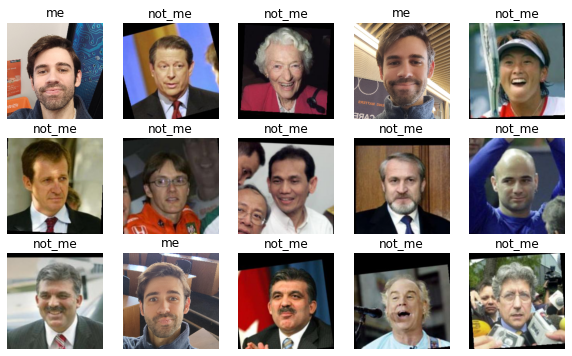

In [ ]:
fig, axs = plt.subplots(3,5, figsize=(10,6))
for _ax in axs:
  for ax in _ax:
    ix = random.randint(0, len(dataset['train'])-1)
    img, lab = dataset['train'][ix]
    ax.imshow(img.permute(1,2,0))
    ax.axis('off')
    ax.set_title(classes[lab])
plt.show()

We then create a dataloader dictionary using three DataLoader objects: one for each data set. Each DataLoader is initialized with its corresponding dataset. We also choose here the batch size and set the argument "shuffle" to "True" to we indicate that the data should be randomly shuffled between epochs. With the last lines we can check that the code works as expected (i.e., a tensor with dimensions equal to the batch_size, channels, height and width, respectively).

In [ ]:
dataloader = {
    # batch size of 50 instances during training
    'train': torch.utils.data.DataLoader(
        dataset['train'], batch_size=50, shuffle=True, pin_memory=True), 
    # we will input all the instances at once for validation 
    'val': torch.utils.data.DataLoader(
        dataset['val'], batch_size=90, shuffle=True),
    # we will input all the instances at once for testing                       
    'test': torch.utils.data.DataLoader(
        dataset['test'], batch_size=39, shuffle=True)                      
}
imgs, labels = next(iter(dataloader['train']))
imgs.shape

torch.Size([50, 3, 224, 224])

# 4. The model: modified Resnet18

## 4.1. Why Resnet18?

ResNet-18 is a widely used CNN for image classification. There are several reasons why we chose this network for the project.

Firstly, it is composed of only 18 layers, which makes the training time shorter than with deeper networks, but still achieves high accuracy in image classification tasks. Secondly, a pre-trained version of the network is publicly available, which allows us to fine-tune it and thus to test the advantages of transfer learning easily. Third, Resnet18 was trained on more than one million images from the ImageNet database (see http://www.image-net.org), and is able to classify images into 1,000 categories. Therefore, it is expected to perform well even with few instances.

Resnet18 architecture and the characteristics of each layer is shown in the Annex I.

## 4.2. Model specifications: adapting the original model

As mentioned, the original Resnet18 is able to classify images in 1000 categories. However, here we want to classify  pictures in just 2 categories (i.e., me or not me). Therefore, we modified its architecture by removing the last layer with 1000 outputs and adding a new linear layer with only 2 to carry out our classification. 

When creating the class, we also added the arguments "pretrained" and "freeze". The former argument allows us to decide, in each experiment, if we want to import the pre-trained weights or not. The latter, makes the weights of the convolutional layers to be updated or to remain the same. This allows us to decide, in each experiment, if we want to train the whole network (freeze=False) or just the last linear layer we created (freeze=True). The function "unfreeze" is explained and used in the fourth experiment.

In [ ]:
class Model(torch.nn.Module):
  def __init__(self, n_outputs=2, pretrained=False, freeze=False):
    super().__init__()
    # downloading resnet
    resnet = torchvision.models.resnet18(weights=pretrained) 
    #before the previous parameter was "pretrained" instead of "weights"

    # selecting all convolutional layers except the last one
    self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
    if freeze:
      for param in self.resnet.parameters():
        param.requires_grad=False

    # adding a linear layer with 2 outputs to conduct the classification
    self.fc = torch.nn.Linear(512, 2)

  def forward(self, x):
    x = self.resnet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.resnet.parameters():
        param.requires_grad=True

## 4.3. Fit and prediction functions

The following code shows the function we use to fit the data and check the model performance in the validation set. Each step is explained in comments in the code.

In [ ]:
def fit(model, dataloader, epochs, lr=1e-3, show_epoch=5):
    # this function is a modified version of another one obtained from
    # https://www.sensiocoders.com/
    # moves the model to the specified device, which could be a CPU or a GPU.
    model.to(device)

    # defines optimizer with stochastic gradient descent and the learning rate
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # the criterion will be cross-entropy loss
    criterion = torch.nn.CrossEntropyLoss()

    # initializes four empty lists to store the loss and accuracy values
    train_loss_epoch,val_loss_epoch,train_acc_epoch,val_acc_epoch = [],[],[],[]

    for epoch in range(1, epochs+1):
      # TRAINING
        model.train()  # puts the model into "train" mode
        train_loss, train_acc = [], []
        bar = dataloader['train']
        #bar = tqdm(dataloader['train']) # uncomment this line to see progress
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device) # applies device object
            optimizer.zero_grad()             # optimizer gradients set to zero
            y_hat = model(X)                  # makes a prediction
            loss = criterion(y_hat, y)        # calculates the loss
            loss.backward()                   # gradients are computed
            optimizer.step()                  # updates optimizer
            train_loss.append(loss.item())    # loss is appended
            # torch.argmax returns the index of class with highest probability
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)             # accuracy is appended
            #  uncomment the following 2 lines to see metrics for each batch:
            #bar.set_description(
                #f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

      # VALIDATION
        bar = dataloader['val']
        #bar = tqdm(dataloader['val'])    # uncomment this line to see progress
        val_loss, val_acc = [], []
        # puts model into "eval" mode and repeats a similar process as before
        model.eval()  
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                #bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        if epoch == 1 or epoch % show_epoch==0:
          print(f"Epoch {epoch}/{epochs} train_loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} train_acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")
        train_loss_epoch.append(np.mean(train_loss)), val_loss_epoch.append(np.mean(val_loss)), train_acc_epoch.append(np.mean(train_acc)), val_acc_epoch.append(np.mean(val_acc))
    
    # The following line prints the last epoch if it was not printed before:
    if epoch % show_epoch != 0: 
      print(f"Epoch {epoch}/{epochs} train_loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} train_acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

    return train_loss_epoch, val_loss_epoch, train_acc_epoch, val_acc_epoch, epochs

We also need a function to make predictions in the test set.

In [ ]:
def predict_test(model):
  model.eval()
  with torch.no_grad():
    for batch in dataloader['test']: #batch size = datatest size-->loops 1 time
      X, y = batch
      X, y = X.to(device), y.to(device)
      y_hat = model(X)
      y_hat = torch.argmax(y_hat, axis=1)
      # move y_hat and y tensors to the CPU to print the confusion matrix later
      y_hat = y_hat.cpu()
      y = y.cpu()
      acc_test = (y == y_hat).sum().item() / len(y)
  return acc_test, y, y_hat

# 5. Experiments

## 5.1. First experiment: deep learning without transfer learning

Chapter III desgined the classes and functions we needed. Now we can conduct the experiments. The first experiment consists of training the model from scratch.

To do this, we set all the arguments of the model to the default ones: pretrained=False and freeze=False. By setting pretrained to False, we do not import the pre-trained weights. By setting freeze to False, we allow the parameters of the convolutional layers to update.

In [ ]:
%%capture
set_seeds(RAND_SEED)
model_1 = Model()

In [ ]:
set_seeds(RAND_SEED)
train_loss_1, val_loss_1, train_acc_1, val_acc_1, epochs_model_1 = fit(model_1, dataloader, epochs=80, show_epoch=5)

Epoch 1/80 train_loss 0.65736 val_loss 0.69393 train_acc 0.67333 val_acc 0.53333
Epoch 5/80 train_loss 0.56221 val_loss 0.69997 train_acc 0.80000 val_acc 0.50000
Epoch 10/80 train_loss 0.46394 val_loss 0.62620 train_acc 0.84333 val_acc 0.55556
Epoch 15/80 train_loss 0.39082 val_loss 0.45385 train_acc 0.88000 val_acc 0.80000
Epoch 20/80 train_loss 0.32168 val_loss 0.39417 train_acc 0.91000 val_acc 0.83333
Epoch 25/80 train_loss 0.27075 val_loss 0.34672 train_acc 0.93000 val_acc 0.84444
Epoch 30/80 train_loss 0.21163 val_loss 0.28464 train_acc 0.95333 val_acc 0.87778
Epoch 35/80 train_loss 0.18156 val_loss 0.26360 train_acc 0.96000 val_acc 0.92222
Epoch 40/80 train_loss 0.16140 val_loss 0.23963 train_acc 0.97000 val_acc 0.90000
Epoch 45/80 train_loss 0.13161 val_loss 0.21046 train_acc 0.98333 val_acc 0.93333
Epoch 50/80 train_loss 0.12270 val_loss 0.18719 train_acc 0.97000 val_acc 0.92222
Epoch 55/80 train_loss 0.11752 val_loss 0.17439 train_acc 0.98667 val_acc 0.93333
Epoch 60/80 train_

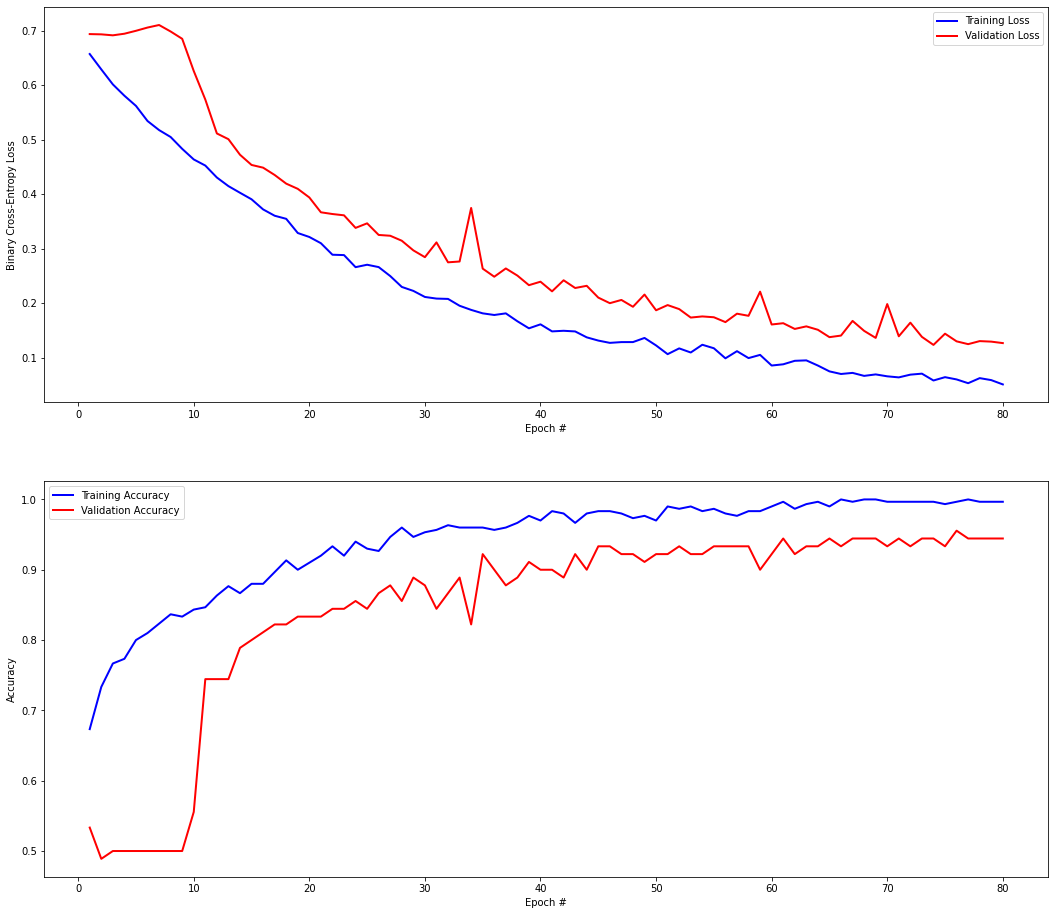

In [ ]:
# Plot the training and validation losses and accuracies
fig, axs = plt.subplots(2, figsize=(18, 16))

# Plot the losses
x = list(range(1, 1+len(train_loss_1)))
axs[0].plot(x, train_loss_1, 'b', linewidth=2)
axs[0].plot(x, val_loss_1, 'r', linewidth=2)
axs[0].set_xlabel('Epoch #')
axs[0].set_ylabel('Binary Cross-Entropy Loss')
axs[0].legend(('Training Loss', 'Validation Loss'))

# Plot the accuracies
x = list(range(1, 1+len(train_acc_1)))
axs[1].plot(x, train_acc_1, 'b', linewidth=2)
axs[1].plot(x, val_acc_1, 'r', linewidth=2)
axs[1].set_xlabel('Epoch #')
axs[1].set_ylabel('Accuracy')
axs[1].legend(('Training Accuracy', 'Validation Accuracy'))

plt.show()

It is possible to see that the model performs very well in both datasets, without overfit the training set. However, it is necessary to train the model for around 80 epochs to get an accuracy close to 100%.

We can also see that the model does not loose accuracy on the test set.

In [ ]:
set_seeds(RAND_SEED)
acc_test_1, y_1, y_hat_1 = predict_test(model_1)
print(f'The accuracy of the resnet trained from scratch is {round(acc_test_1*100,2)}%')

The accuracy of the resnet trained from scratch is 100.0%


In the following chapters we show how transfer learning helps us to obtain better metrics even with a smaller number of epochs.

## 5.2. Second experiment: transfer learning training only lineal layer

The first experiment consisted of training the CNN from scratch, without transfer learning. Now we will import resnet18's pre-trained weights and train only the last linear layer we created.

To do this, we set pretrained=True and freeze=False in the "Model" class. By setting pretrained to True, we import the pre-trained weights. By setting freeze to True, we do not allow the weights of the convolutional layers to be updated, but only those of the last linear layer.

In [ ]:
%%capture
set_seeds(RAND_SEED)
model_2 = Model(pretrained=True, freeze=True)

In [ ]:
set_seeds(RAND_SEED)
train_loss, val_loss, train_acc, val_acc, epochs_model_2 = fit(model_2, dataloader, epochs=35, show_epoch=5)

Epoch 1/35 train_loss 0.72664 val_loss 0.69256 train_acc 0.48333 val_acc 0.48889
Epoch 5/35 train_loss 0.49540 val_loss 0.48180 train_acc 0.85000 val_acc 0.87778
Epoch 10/35 train_loss 0.34164 val_loss 0.32841 train_acc 0.96333 val_acc 0.95556
Epoch 15/35 train_loss 0.27593 val_loss 0.25265 train_acc 0.97333 val_acc 0.98889
Epoch 20/35 train_loss 0.21969 val_loss 0.20438 train_acc 0.98333 val_acc 0.98889
Epoch 25/35 train_loss 0.18469 val_loss 0.17182 train_acc 0.99000 val_acc 1.00000
Epoch 30/35 train_loss 0.14584 val_loss 0.14836 train_acc 1.00000 val_acc 1.00000
Epoch 35/35 train_loss 0.12943 val_loss 0.13082 train_acc 1.00000 val_acc 1.00000


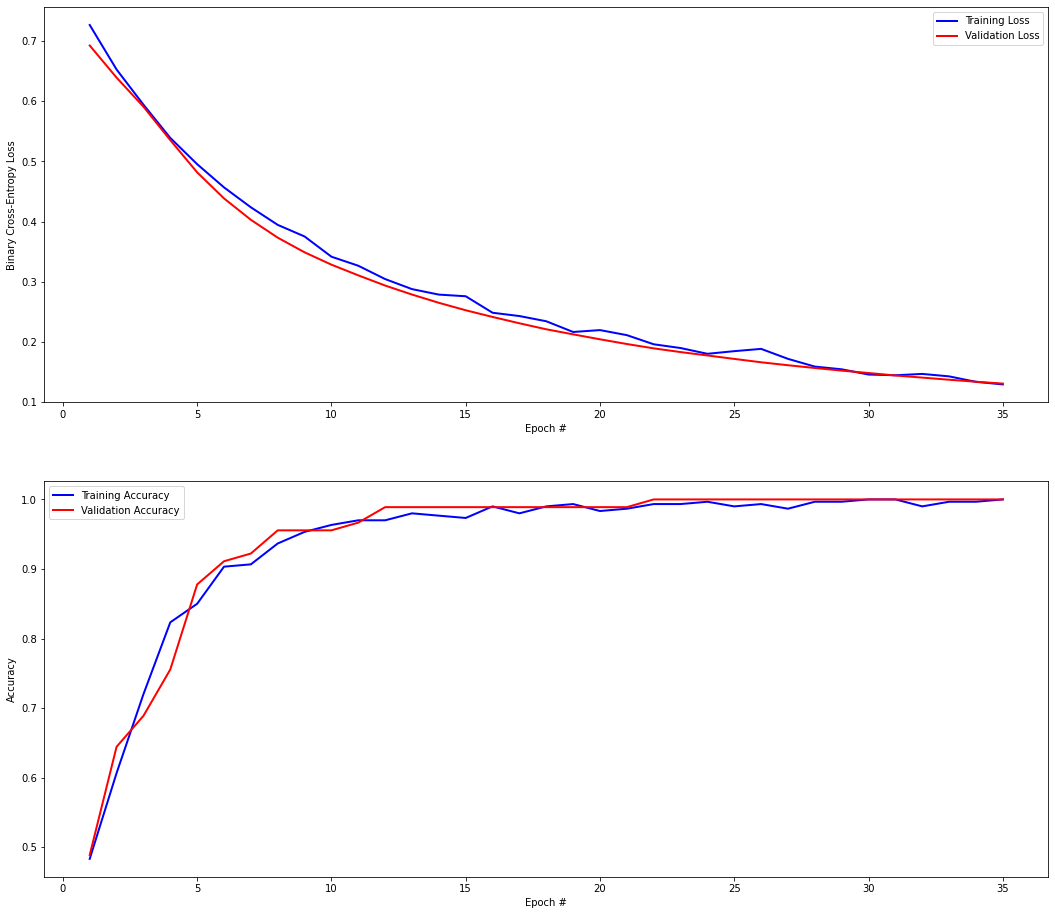

In [ ]:
# Plot the training and validation losses and accuracies
fig, axs = plt.subplots(2, figsize=(18, 16))

# Plot the losses
x = list(range(1, 1+len(train_loss)))
axs[0].plot(x, train_loss, 'b', linewidth=2)
axs[0].plot(x, val_loss, 'r', linewidth=2)
axs[0].set_xlabel('Epoch #')
axs[0].set_ylabel('Binary Cross-Entropy Loss')
axs[0].legend(('Training Loss', 'Validation Loss'))

# Plot the accuracies
x = list(range(1, 1+len(train_acc)))
axs[1].plot(x, train_acc, 'b', linewidth=2)
axs[1].plot(x, val_acc, 'r', linewidth=2)
axs[1].set_xlabel('Epoch #')
axs[1].set_ylabel('Accuracy')
axs[1].legend(('Training Accuracy', 'Validation Accuracy'))

plt.show()

Two facts are worth it to be noted after running this experiment. First, the results show that we get a better model in fewer epochs (in experiment one we needed 80 epochs). Second, each epoch takes less time to complete since we are training only the last layer. 

We can now retrain the model with the optimum number of epochs and test its performance in the test set. We can check that, in the test set, the accuracy is also 100%.

In [ ]:
%%capture
set_seeds(RAND_SEED)
model_2 = Model(pretrained=True, freeze=True)

In [ ]:
%%capture
set_seeds(RAND_SEED)
train_loss_2, val_loss_2, train_acc_2, val_acc_2, epochs_model_2 = fit(model_2, dataloader, epochs=30, show_epoch=5)

In [ ]:
set_seeds(RAND_SEED)
acc_test_2, y_2, y_hat_2 = predict_test(model_2)
print(f'With transfer learning, the accuracy of the network when training only the last linear layer is {round(acc_test_2*100,2)}%')

With transfer learning, the accuracy of the network when training only the last linear layer is 100.0%


## 5.3. Third experiment: transfer learning training the whole network

The second experiment imported the pretrained weights and trained only the last linear layer. We now try to improve the network more by fine-tuning it. In other words: we train the whole network but starting with the pretrained weights. This will make each epoch to take longer to be completed than in experiment 2, but theoretically we will need less epochs to achieve our goal, since now out model is more flexible than before.

In [ ]:
%%capture
set_seeds(RAND_SEED)
model_3 = Model(pretrained=True, freeze=False)

In [ ]:
set_seeds(RAND_SEED)
train_loss, val_loss, train_acc, val_acc, epochs_model_3 = fit(model_3, dataloader, epochs=15, show_epoch=3)

Epoch 1/15 train_loss 0.69642 val_loss 0.64181 train_acc 0.54000 val_acc 0.64444
Epoch 3/15 train_loss 0.46802 val_loss 0.45952 train_acc 0.89667 val_acc 0.81111
Epoch 6/15 train_loss 0.29409 val_loss 0.27885 train_acc 0.97667 val_acc 0.97778
Epoch 9/15 train_loss 0.21573 val_loss 0.19993 train_acc 0.98667 val_acc 1.00000
Epoch 12/15 train_loss 0.15521 val_loss 0.15797 train_acc 1.00000 val_acc 1.00000
Epoch 15/15 train_loss 0.13830 val_loss 0.12825 train_acc 1.00000 val_acc 1.00000


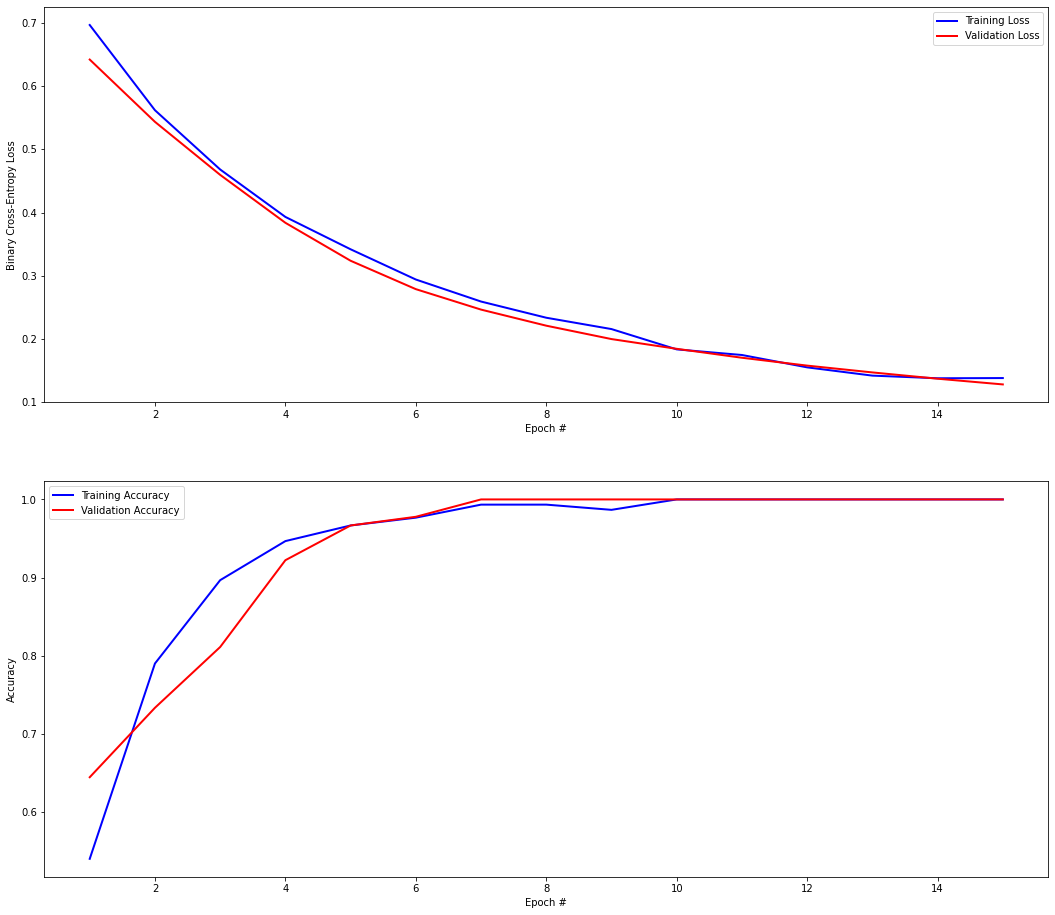

In [ ]:
# Plot the training and validation losses and accuracies
fig, axs = plt.subplots(2, figsize=(18, 16))

# Plot the losses
x = list(range(1, 1+len(train_loss)))
axs[0].plot(x, train_loss, 'b', linewidth=2)
axs[0].plot(x, val_loss, 'r', linewidth=2)
axs[0].set_xlabel('Epoch #')
axs[0].set_ylabel('Binary Cross-Entropy Loss')
axs[0].legend(('Training Loss', 'Validation Loss'))

# Plot the accuracies
x = list(range(1, 1+len(train_acc)))
axs[1].plot(x, train_acc, 'b', linewidth=2)
axs[1].plot(x, val_acc, 'r', linewidth=2)
axs[1].set_xlabel('Epoch #')
axs[1].set_ylabel('Accuracy')
axs[1].legend(('Training Accuracy', 'Validation Accuracy'))

plt.show()

In the same way as in the previous experiments, we train the model again with the correct number of epochs and test it with the test set. We can check that, in the test set, the accuracy is also 100%.

In [ ]:
%%capture
set_seeds(RAND_SEED)
model_3 = Model(pretrained=True, freeze=False)

In [ ]:
%%capture
set_seeds(RAND_SEED)
train_loss_3, val_loss_3, train_acc_3, val_acc_3, epochs_model_3 = fit(model_3, dataloader, epochs=12, show_epoch=3)

In [ ]:
set_seeds(RAND_SEED)
acc_test_3, y_3, y_hat_3 = predict_test(model_3)
print(f'With transfer learning, the accuracy of the network when training all the layers is {round(acc_test_3*100,2)}%')

With transfer learning, the accuracy of the network when training all the layers is 100.0%


## 5.4. Fourth experiment: transfer learning in two steps

Our final experiment combines the two previous experiments. We first train the model for several epochs without fine-tunning the pre-trained network (i.e., we set pre-trained=True and freezing=True). This involves training only the last linear layer. We then "unfreeze" the network and allow all weights in the network to be updated. During the first step, we train with a higher learning rate than during the second step, as it must be remembered that the last linear layer was created ad hoc for this project and must therefore be trained from scratch.

In [ ]:
%%capture
set_seeds(RAND_SEED)
model_4 = Model(pretrained=True, freeze=True)

In [ ]:
set_seeds(RAND_SEED)
step1_train_loss, step1_val_loss, step1_train_acc, step1_val_acc, epochs_model_4_1 = fit(
    model_4, dataloader, epochs=5, lr=5e-3, show_epoch=2)
model_4.unfreeze()
step2_train_loss, step2_val_loss, step2_train_acc, step2_val_acc, epochs_model_4_2 = fit(
    model_4, dataloader, epochs=15, lr=1e-4, show_epoch=2)

epochs_model_4 = epochs_model_4_1 + epochs_model_4_2
concatenated_train_loss = step1_train_loss + step2_train_loss
concatenated_val_loss = step1_val_loss + step2_val_loss
concatenated_train_acc = step1_train_acc + step2_train_acc
concatenated_val_acc = step1_val_acc + step2_val_acc

Epoch 1/5 train_loss 0.62383 val_loss 0.51250 train_acc 0.67000 val_acc 0.84444
Epoch 2/5 train_loss 0.40341 val_loss 0.37927 train_acc 0.93667 val_acc 0.90000
Epoch 4/5 train_loss 0.23261 val_loss 0.22614 train_acc 0.99000 val_acc 1.00000
Epoch 5/5 train_loss 0.19406 val_loss 0.18596 train_acc 0.99000 val_acc 1.00000
Epoch 1/15 train_loss 0.17060 val_loss 0.17532 train_acc 0.99333 val_acc 1.00000
Epoch 2/15 train_loss 0.16884 val_loss 0.16863 train_acc 0.99667 val_acc 1.00000
Epoch 4/15 train_loss 0.17299 val_loss 0.16334 train_acc 0.99000 val_acc 1.00000
Epoch 6/15 train_loss 0.16438 val_loss 0.16145 train_acc 1.00000 val_acc 1.00000
Epoch 8/15 train_loss 0.15686 val_loss 0.15854 train_acc 1.00000 val_acc 1.00000
Epoch 10/15 train_loss 0.16969 val_loss 0.15575 train_acc 0.99333 val_acc 1.00000
Epoch 12/15 train_loss 0.15785 val_loss 0.15309 train_acc 0.99667 val_acc 1.00000
Epoch 14/15 train_loss 0.14820 val_loss 0.15066 train_acc 0.99667 val_acc 1.00000
Epoch 15/15 train_loss 0.1573

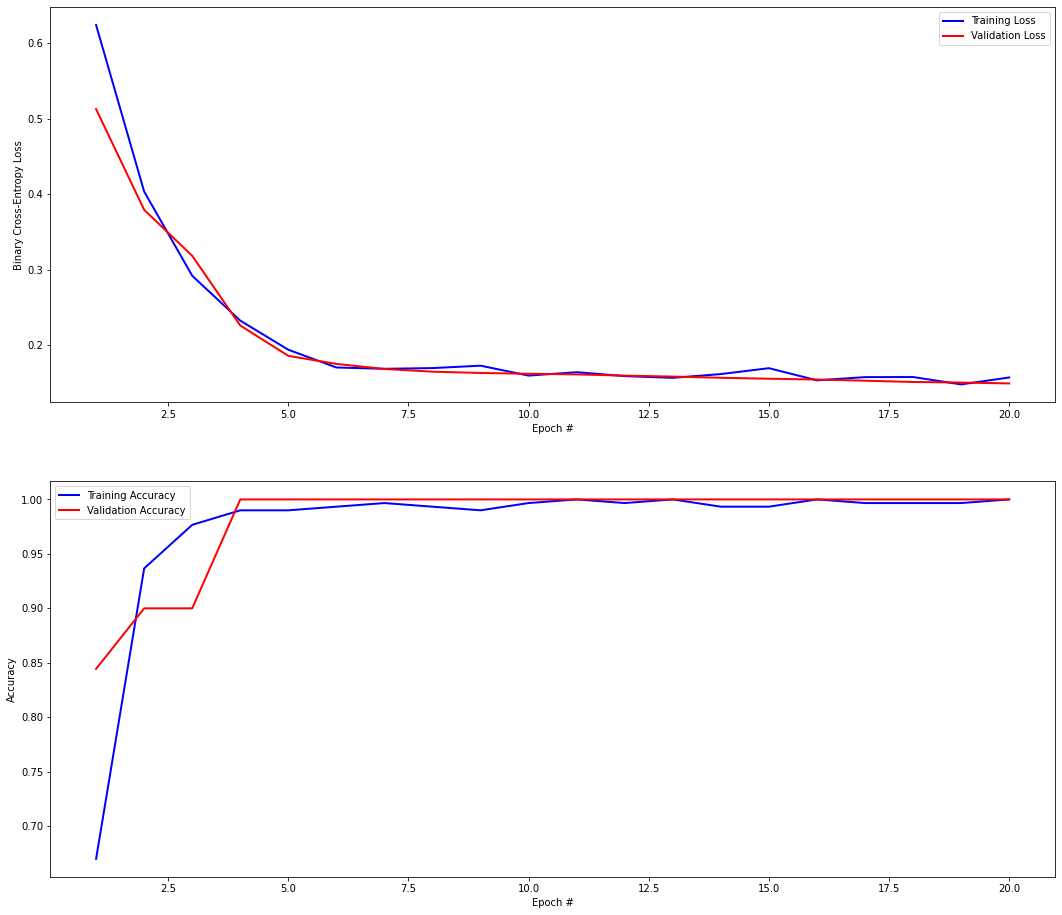

In [ ]:
# Plot the training and validation losses and accuracies
fig, axs = plt.subplots(2, figsize=(18, 16))

# Plot the losses
x = list(range(1, 1+len(concatenated_train_loss)))
axs[0].plot(x, concatenated_train_loss, 'b', linewidth=2)
axs[0].plot(x, concatenated_val_loss, 'r', linewidth=2)
axs[0].set_xlabel('Epoch #')
axs[0].set_ylabel('Binary Cross-Entropy Loss')
axs[0].legend(('Training Loss', 'Validation Loss'))

# Plot the accuracies
x = list(range(1, 1+len(concatenated_train_acc)))
axs[1].plot(x, concatenated_train_acc, 'b', linewidth=2)
axs[1].plot(x, concatenated_val_acc, 'r', linewidth=2)
axs[1].set_xlabel('Epoch #')
axs[1].set_ylabel('Accuracy')
axs[1].legend(('Training Accuracy', 'Validation Accuracy'))

plt.show()

As in the previous experiments, we train again the model with the correct number of epochs and test it in the test set. Note that, in the test set, the accuracy is also 100%.

In [ ]:
%%capture
set_seeds(RAND_SEED)
model_4 = Model(pretrained=True, freeze=True)

In [ ]:
%%capture
set_seeds(RAND_SEED)
step1_train_loss_4_1, step1_val_loss_4_1, step1_train_acc_4_1, step1_val_acc_4_1, epochs_model_4_1 = fit(
    model_4, dataloader, epochs=5, lr=5e-3, show_epoch=2)
model_4.unfreeze()
step2_train_loss_4_2, step2_val_loss_4_2, step2_train_acc_4_2, step2_val_acc_4_2, epochs_model_4_2 = fit(
    model_4, dataloader, epochs=2, lr=1e-4, show_epoch=2)

epochs_model_4 = epochs_model_4_1 + epochs_model_4_2
concatenated_train_loss_4 = step1_train_loss_4_1 + step2_train_loss_4_2
concatenated_val_loss_4 = step1_val_loss_4_1 + step2_val_loss_4_2
concatenated_train_acc_4 = step1_train_acc_4_1 + step2_train_acc_4_2
concatenated_val_acc_4 = step1_val_acc_4_1 + step2_val_acc_4_2

In [ ]:
set_seeds(RAND_SEED)
acc_test_4, y_4, y_hat_4 = predict_test(model_4)
print(f'With transfer learning, the accuracy of the network trained in two steps is {round(acc_test_4*100,2)}%')

With transfer learning, the accuracy of the network trained in two steps is 100.0%


# 6. Error analysis

The accuracy reached with each model on the test set, the number of epochs needed to achieve it and the confusion matrixes are shown as follows.

In [ ]:
print(f'Experiment 1. No transfer learning. \n Training from scratch. Accuracy: {round(acc_test_1*100,2)}% \n Epochs needed: {epochs_model_1}\n')
print(f'Experiment 2. Transfer learning. \n Training only the last linear layer. Accuracy: {round(acc_test_2*100,2)}% \n Epochs needed: {epochs_model_2}\n')
print(f'Experiment 3. Transfer learning. \n Training all the layers. Accuracy: {round(acc_test_3*100,2)}% \n Epochs needed: {epochs_model_3}\n')
print(f'Experiment 4. Transfer learning. \n Training in two steps. Accuracy: {round(acc_test_4*100,2)}% \n Epochs needed: {epochs_model_4}\n')

Experiment 1. No transfer learning. 
 Training from scratch. Accuracy: 100.0% 
 Epochs needed: 80

Experiment 2. Transfer learning. 
 Training only the last linear layer. Accuracy: 100.0% 
 Epochs needed: 30

Experiment 3. Transfer learning. 
 Training all the layers. Accuracy: 100.0% 
 Epochs needed: 12

Experiment 4. Transfer learning. 
 Training in two steps. Accuracy: 100.0% 
 Epochs needed: 7



In [ ]:
labels_confusion = ["me", "not_me"]
cm_model_1 = confusion_matrix(y_1, y_hat_1)
disp_cm_model_1 = ConfusionMatrixDisplay(confusion_matrix=cm_model_1, display_labels=labels_confusion)
cm_model_2 = confusion_matrix(y_2, y_hat_2)
disp_cm_model_2 = ConfusionMatrixDisplay(confusion_matrix=cm_model_2, display_labels=labels_confusion)
cm_model_3 = confusion_matrix(y_3, y_hat_3)
disp_cm_model_3 = ConfusionMatrixDisplay(confusion_matrix=cm_model_3, display_labels=labels_confusion)
cm_model_4 = confusion_matrix(y_4, y_hat_4)
disp_cm_model_4 = ConfusionMatrixDisplay(confusion_matrix=cm_model_4, display_labels=labels_confusion)


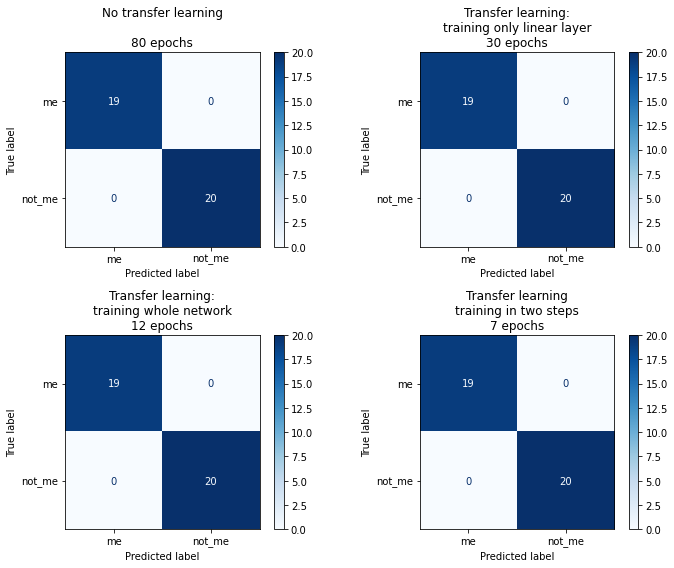

In [ ]:
# Create a 2x2 grid of subplots and plot each confusion matrix in a different subplot

# CHANGE SET_TITLE SO IT AUTOMATICALLY TAKES NUM_EPOCHS_1 2 ETC

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

disp_cm_model_1.plot(ax=axs[0, 0], cmap='Blues')
axs[0, 0].set_title("No transfer learning\n\n80 epochs")

disp_cm_model_2.plot(ax=axs[0, 1], cmap='Blues')
axs[0, 1].set_title("Transfer learning:\ntraining only linear layer\n30 epochs")

disp_cm_model_3.plot(ax=axs[1, 0], cmap='Blues')
axs[1, 0].set_title("Transfer learning:\ntraining whole network\n12 epochs")

disp_cm_model_4.plot(ax=axs[1, 1], cmap='Blues')
axs[1, 1].set_title("Transfer learning\ntraining in two steps\n7 epochs")

plt.tight_layout()
plt.show()

Note that all models achieved a 100% accuracy on the three datasets (including the test set, as shown in the confusion matrixes). Therefore, we did not need to conduct a grid search. On the other hand, we did not use regularization techniques because the model seems highly generalizable (accuracy of 100% in both the validation and the test sets).

# 7. Transfer learning for face recognition: conclusions, limitations and future research

The aim of the work was to investigate transfer learning as an effective way to train CNNs for face recognition. The commercial application of the project was to provide users with a tool that automatically detects the images in which they appear. This chapter shows the conclusions and limitations of the work, and suggests future research to make the model marketable.

## 7.1. Conclusions

All the models trained achieved extremely high accuracy rates on all datasets, but both the required number of epochs and the time needed to complete each epoch varied considerably across them.

Without transfer learning, we needed 80 epochs to train the model, and each epoch took considerably long to be completed.

In the second experiment, with transfer learning, we only needed 30 epochs to reach an accuracy rate close to 100% on the test set. Therefore, transfer learning can help save money by allowing data scientists to train their models with fewer computational resources.

In the third experiment, all layers of the network were retrained. This resulted in each epoch taking longer to complete but in fewer epochs to complete the training.

With the fourth experiment, we can reach a very interesting conclusion: training only the last layer with a higher learning rate is sufficient to achieve similar accuracy rates as before, but with fewer epochs. This seems to imply that the Resnet18 weights are already good enough to make accurate predictions on our dataset, so training the last layer is sufficient.

## 7.2. Limitations and future research

The main limitations of the work are due to the dataset, as it only contains images of faces. However, images of social events are often more complex (e.g., several people appear, more objects are shown, etc.). This can make the network perform worse on other datasets.

Therefore, two non-exclusive approaches are suggested to solve this potential problem and make the product marketable. First, retraining with images taken during events. Second, create a new AI that first detects faces in an image (without classifying them) and then perform classification by focusing only on that fraction of the image.

# 8. Annex

## 8.1. Annex I. Sample of the dataset created for the assignment

This annex shows a sample of the pictures taken before adapting them for the model.

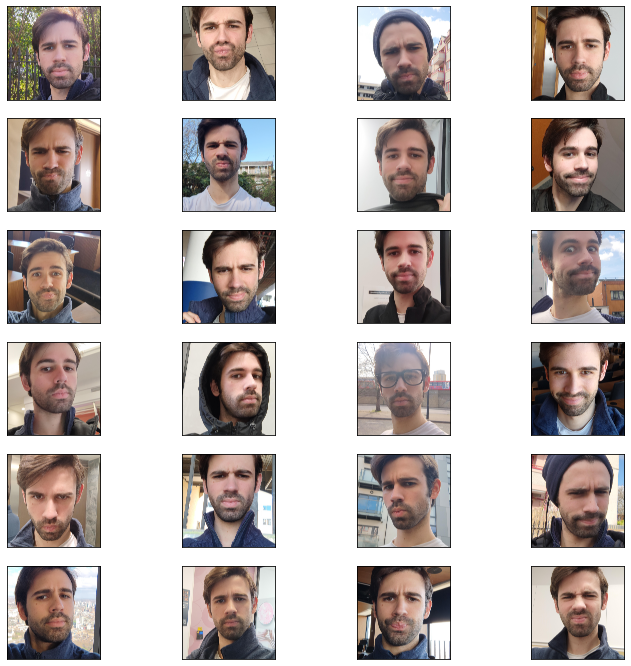

In [ ]:
set_seeds(RAND_SEED)
# Set the path to the directory containing the images
path = '/content/new_people/me/'

# Get the list of all the image files in the directory
image_files = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

# Shuffle the list of image files
random.seed(RAND_SEED)
random.shuffle(image_files)

# Take the first 50 image files
image_files = image_files[:24]

# Define the size of the subplot grid
num_cols = 4
num_rows = (len(image_files) // num_cols)

# Create a new figure and set the size of the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Loop through the image files and display each one in a subplot
for i, image_file in enumerate(image_files):
    # Open the image file
    image = Image.open(image_file)

    # Rotate the image by 90 degrees
    #image = image.rotate(90)

    # Calculate the row and column indices for the subplot
    row_idx = i // num_cols
    col_idx = i % num_cols

    # Display the image in the subplot
    axs[row_idx, col_idx].imshow(image)

    # Remove the axis labels and ticks from the subplot
    axs[row_idx, col_idx].set_xticks([])
    axs[row_idx, col_idx].set_yticks([])

# Show the plot
plt.show()

## 8.2. Annex II. Resnet18 architecture

In [ ]:
resnet = torchvision.models.resnet18()
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  